In [1]:
import os
import copy
import numpy as np
import itertools
import matplotlib.pyplot as plt
import krippendorff
from endoanalysis.dataset import PointsDataset
from endoanalysis.agreement import OKSimilarity, compose_batch_relaibility_matrix


In [2]:
agreement_dir = "../../points-detection/data/agreement/"
experts = [ "alexandra", "tatyana", "ekaterina", "maria", "nikita", "olesya", "konstantin"]

datasets = {}
dataloaders = {}
datasets_lens = {}
keypoints  = {}
datasets = {}

for annotator_name in experts:
    files_list = os.path.join(agreement_dir, annotator_name, "all.txt")
    dataset = PointsDataset(
        files_list, 
        keypoints_dtype = float
    )
    datasets_lens[annotator_name] = len(dataset)
    datasets[annotator_name] = dataset
    
    keypoints[annotator_name] = dataset.collate()["keypoints"]
#     keypoints[annotator_name] = next(iter(dataloader))["keypoints"]
    

In [3]:
datasets_lens_list = list(datasets_lens.values())
if len(np.unique(datasets_lens_list)) != 1:
    raise Exception("Some annotators have different numbe of images than the others")
else:
    num_images = datasets_lens_list[0]

In [4]:
similarity = OKSimilarity(scale=7.36)

In [5]:
experts = ['alexandra', 'tatyana', 'konstantin']

In [6]:
relaibility_matrix = compose_batch_relaibility_matrix(
    keypoints,
    experts, 
    OKSimilarity(scale=7.36), 
    sim_thresh=0.5, 
    images_indexes=[0,1,2,3,4,5,6,7,8,9], 
    missings_as_classes=False, 
    class_agnostic=False
)

In [8]:
krippendorff.alpha(relaibility_matrix, level_of_measurement="nominal")

0.7524699579571368

In [13]:
base_experts = [  "tatyana"]
for student in ["ekaterina", "maria", "nikita", "olesya"]:
    experts = base_experts + [student]
    relaibility_matrix = compose_batch_relaibility_matrix(
        keypoints, 
        experts, 
        OKSimilarity(scale=7.36), 
        sim_thresh=0.5, 
        images_indexes=list(range(10)), 
        missings_as_classes=False, 
        class_agnostic=False
    )
    alpha = krippendorff.alpha(relaibility_matrix, level_of_measurement="nominal")
    print(student, alpha)

ekaterina 0.24947165679064265
maria 0.27076376188470297
nikita 0.2685662085088737
olesya 0.830132492925135


In [17]:
experts = [ "alexandra", "tatyana", 'konstantin', "ekaterina", "maria", "nikita", "olesya"]

In [18]:
num_images = 10
keypoints_nums = np.zeros((len(experts), num_images))

for expert_i, expert in enumerate(experts):
    keypoints_num_expert = [len(keypoints[expert].from_image(image_i)) for image_i in range(num_images)]
    keypoints_nums[expert_i] = np.array(keypoints_num_expert)


In [19]:
krippendorff.alpha(reliability_data=keypoints_nums, level_of_measurement="ordinal")

0.8304877317100609

In [20]:
num_images = 10
base_experts = [  "tatyana"]
for student in ["ekaterina", "maria", "nikita", "olesya"]:
    experts = base_experts + [student]
    
    keypoints_nums = np.zeros((len(experts), num_images))

    for expert_i, expert in enumerate(experts):
        keypoints_num_expert = [len(keypoints[expert].from_image(image_i)) for image_i in range(num_images)]
        keypoints_nums[expert_i] = np.array(keypoints_num_expert)
    alpha = krippendorff.alpha(reliability_data=keypoints_nums, level_of_measurement="ordinal")
    print(student, alpha)

ekaterina 0.9028571428571428
maria 0.8542857142857143
nikita 0.5971428571428572
olesya 0.78


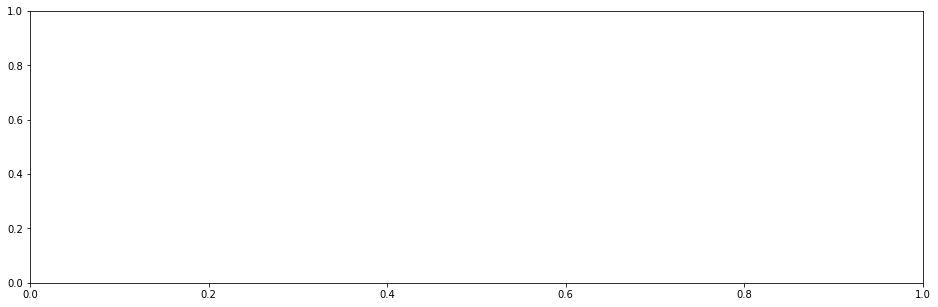

In [9]:
experts = [ "alexandra", "tatyana", 'konstantin', "ekaterina", "maria", "nikita", "olesya"]

# experts = [ "alexandra", "tatyana", 'konstantin']
# fig, ax = plt.subplots(1, figsize=(16,5))

# keypoints_nums = np.zeros((len(experts), num_images))

# for expert_i, expert in enumerate(experts):
#     keypoints_num_expert = [len(keypoints[expert].from_image(image_i)) for image_i in range(num_images)]
#     keypoints_nums[expert_i] = np.array(keypoints_num_expert)

# x = np.arange(10)
# for idx in range(len(experts)):
#     ax.set_xticks(np.arange(10))
#     ax.bar(x - idx*0.12 , keypoints_nums[idx], width=0.12 , align='center', edgecolor='black', zorder=1)
#     ax.legend(experts)
#     ax.grid(b=True,axis="y", zorder=2)
    

In [26]:
krippendorff.alpha(reliability_data=keypoints_nums, level_of_measurement="ordinal")

0.8304877317100609